# Late Fusion Model - CMU-MOSI Dataset

In [1]:
!git clone https://github.com/M-Jafarkhani/Multimodal-Sentiment-Analysis

Cloning into 'Multimodal-Sentiment-Analysis'...
remote: Enumerating objects: 565, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 565 (delta 9), reused 36 (delta 3), pack-reused 521 (from 2)
Receiving objects: 100% (565/565), 428.85 MiB | 14.65 MiB/s, done.
Resolving deltas: 100% (246/246), done.
Updating files: 100% (41/41), done.


In [2]:
!pip install memory_profiler

In [3]:
import gdown

file_id = "1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU"
destination = "mosi_raw.pkl"

gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU
From (redirected): https://drive.google.com/uc?id=1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU&confirm=t&uuid=dd234cde-f744-4e30-a09c-69dfdecd87a0
To: /content/mosi_raw.pkl
100%|██████████| 357M/357M [00:05<00:00, 70.2MB/s]


'mosi_raw.pkl'

## Importing Libraries

In [4]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Sentiment-Analysis/src')

## Importing Helper Functions

In [5]:
from loader import get_dataloader
from unimodals.modules import GRU, MLP
from training.supervised import train, test
from fusions.modules import Concat
from utils import get_default_device, save_results

## Loading the Dataset

In [6]:
train_data, valid_data, test_data = get_dataloader('/content/mosi_raw.pkl')

In [7]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [8]:
encoders = [
    GRU(35, 70, dropout=True, has_padding=True, batch_first=True).to(device),
    GRU(74, 200, dropout=True, has_padding=True, batch_first=True).to(device),
    GRU(300, 600, dropout=True, has_padding=True, batch_first=True).to(device),
]
head = MLP(870, 870, 1).to(device)
fusion = Concat().to(device)


## Training

In [9]:
OUTPUT_MODEL_FILE_NAME = 'MOSI_Late_Fusion'
train_losses, valid_losses = train(
    encoders,
    fusion,
    head,
    train_data,
    valid_data,
    100,
    task="regression",
    optimtype=torch.optim.AdamW,
    early_stop=False,
    is_packed=True,
    lr=1e-3,
    save=f"/content/{OUTPUT_MODEL_FILE_NAME}.pt",
    weight_decay=0.01,
    objective=torch.nn.L1Loss(),
)


Epoch [1/100]
Train Loss: 1.2586
Valid Loss: 1.1852
Saving Best

Epoch [2/100]
Train Loss: 1.0355
Valid Loss: 1.0406
Saving Best

Epoch [3/100]
Train Loss: 0.8748
Valid Loss: 1.0243
Saving Best

Epoch [4/100]
Train Loss: 0.8015
Valid Loss: 0.9372
Saving Best

Epoch [5/100]
Train Loss: 0.7608
Valid Loss: 0.9108
Saving Best

Epoch [6/100]
Train Loss: 0.6798
Valid Loss: 0.8851
Saving Best

Epoch [7/100]
Train Loss: 0.6319
Valid Loss: 0.9631

Epoch [8/100]
Train Loss: 0.6105
Valid Loss: 0.9775

Epoch [9/100]
Train Loss: 0.6071
Valid Loss: 0.8763
Saving Best

Epoch [10/100]
Train Loss: 0.5207
Valid Loss: 0.9120

Epoch [11/100]
Train Loss: 0.4610
Valid Loss: 0.9158

Epoch [12/100]
Train Loss: 0.4470
Valid Loss: 0.9026

Epoch [13/100]
Train Loss: 0.3995
Valid Loss: 0.9030

Epoch [14/100]
Train Loss: 0.3558
Valid Loss: 0.9257

Epoch [15/100]
Train Loss: 0.3624
Valid Loss: 0.9112

Epoch [16/100]
Train Loss: 0.3174
Valid Loss: 0.9423

Epoch [17/100]
Train Loss: 0.3048
Valid Loss: 0.9484

Epoch [

Text(0.5, 1.0, 'Loss vs. No. of epochs')

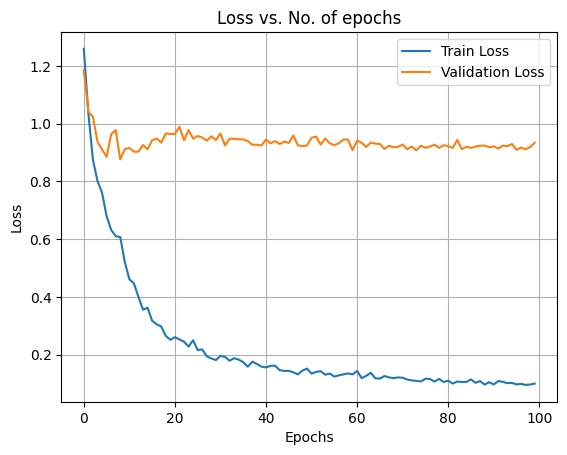

In [10]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [11]:
save_results(train_losses, valid_losses, f"/content/{OUTPUT_MODEL_FILE_NAME}.pkl")

## Testing

In [12]:
model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)
test(
    model,
    test_dataloaders_all=test_data,
    is_packed=True,
    criterion=torch.nn.L1Loss(),
    task="posneg-classification"
)


<ipython-input-12-b8d14d77f9c5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)


Recall: 75.4573% | Total Accuracy: 75.2187%
Inference Time: 349ms
Inference Params: 2570311
